In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.io import FixedLenFeature 
from tensorflow.train import Features, Feature, Example, BytesList, Int64List
from tensorflow.data import Dataset, TFRecordDataset 
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential

!pip install -q efficientnet
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets

import random
import os
import gc
import datetime

In [371]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() 
GCS_PATH_SELECT = { 
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
IMAGE_SIZE = [IMG_DIM, IMG_DIM] 
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

In [372]:
BATCH_SIZE = 128
IMG_DIM = 512
IMG_SIZE = [IMG_DIM, IMG_DIM]

In [373]:
filenames_train = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
filenames_valid = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
filenames_test = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

In [374]:
def image_decode(image):

    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMG_SIZE, 3])

    return image

In [375]:
def read_Labeled_TFRecord(dataset):
    features = {
                'image': FixedLenFeature([], tf.string),
                'id': FixedLenFeature([], tf.string),
                'class': FixedLenFeature([], tf.int64)
                }
    example = tf.io.parse_single_example(dataset, features=features)
    image = image_decode(example['image'])
    label = tf.cast(example['class'], tf.int32)

    return image, label

In [376]:
def read_Unlabeled_TFRecord(dataset):
    features = {
                'image': FixedLenFeature([], tf.string),
                'id': FixedLenFeature([], tf.string)
                }
    example = tf.io.parse_single_example(dataset, features=features)
    image = image_decode(example['image'])

    return image

In [377]:
def load_data_train(filename):
    
    dataset = TFRecordDataset(filename)
    dataset = dataset.map(read_Labeled_TFRecord)
    dataset = dataset.shuffle(buffer_size = len(filename))
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [378]:
def load_data_val_test(filename, labeled = True):
    
    dataset = TFRecordDataset(filename)
    dataset = dataset.map(read_Labeled_TFRecord if labeled else read_Unlabeled_TFRecord)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [379]:
def get_weights(filenames):
    """
    Count the repetition rate of each label and adjust its weight
    """
    dataset = TFRecordDataset(filenames)
    dataset = dataset.map(read_Labeled_TFRecord)
    train_lb = []
    for img, lbel in dataset:
        train_lb.append(lbel.numpy())
    total_num = len(train_lb)
    # count the number of times each label is repeated
    uniq, cnts = np.unique(train_lb, return_counts=1)
    weights = {}
    for i, key in enumerate(uniq):
        weights[key] = 1/cnts[i]*total_num/len(uniq) 
    
    return weights

In [380]:
train_data = load_data_train(filenames_train)
valid_data = load_data_val_test(filenames_valid)
class_weights = get_weights(filenames_train)

In [382]:
def show_8_images(dataset):

    rnd_num = random.randint(1, BATCH_SIZE)
    for IMG, label in dataset.take(rnd_num):
         Example_image = IMG
         Example_label = label

    plt.figure(figsize= (10, 5))
    for i in range(8):
         ax = plt.subplot(2, 4, i+1)
         plt.imshow(Example_image[i])
         plt.title(Example_label[i].numpy())
         plt.axis('off')

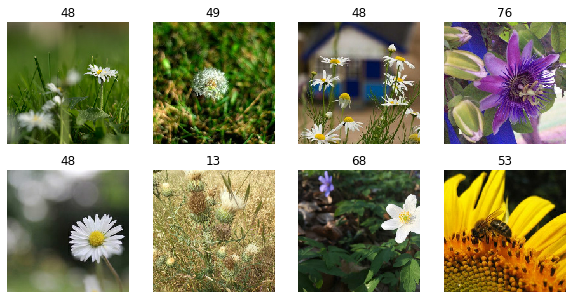

In [383]:
show_8_images(train_data)

# Creating and training a model

In [384]:
INPUT_SHAPE = [IMG_DIM, IMG_DIM, 3]
OUTPUT_SIZE = 104

In [385]:
def create_model(pretrained = False):
    model = []
    if pretrained:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key = os.path.getctime)
    else:
        with strategy.scope():
            img_inp = Input(shape = INPUT_SHAPE, name= 'img_inp')
            efnB3 = efn.EfficientNetB3(weights = 'imagenet', include_top = False)
            x = efnB3(img_inp)
            x = GlobalAveragePooling2D()(x)
            outputs = Dense(OUTPUT_SIZE, activation = 'softmax')(x)
    
            model = tf.keras.models.Model(inputs = img_inp, outputs = outputs)
                           
            
            model.compile(
                optimizer = tf.keras.optimizers.SGD(lr = 1e-2),
                loss = 'sparse_categorical_crossentropy',
                metrics = 'sparse_categorical_accuracy')
            
            model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
            
    return model

In [386]:
model = create_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [387]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 4)
Rate = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1, verbose = 0, mode = 'auto', cooldown = 0, min_lr= 1e-6)

In [388]:
NUM_EPOCH = 100
gc.collect()

69115

In [389]:
history = model.fit(train_data, epochs = NUM_EPOCH, validation_data= valid_data, validation_freq= 1, callbacks = [EarlyStopping, Rate], class_weight=class_weights)

Epoch 1/100
200/200 [==============================] - 2683s 13s/step - loss: 4.7241 - sparse_categorical_accuracy: 0.0110 - val_loss: 4.7123 - val_sparse_categorical_accuracy: 0.0073 - lr: 0.0010
Epoch 2/100
 56/200 [=======>......................] - ETA: 30:43 - loss: 4.6840 - sparse_categorical_accuracy: 0.0123

KeyboardInterrupt: 

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
sfx = "EfficientNet3B"
#save_model(model, suffix=sfx)